## Analizador Bioimagenes C. elegans - Conteo diferencial de núcleos fluorescentes

### 1 - Instalar librerias necesarias:

In [ ]:
!pip install bioio 
!pip install bioio_bioformats 
!pip install opencv-python
!pip install matplotlib
!pip install seaborn

### 2 - Importar librerias necesarias 

In [2]:
from bioio import BioImage 
import bioio_bioformats
import numpy as np  
import cv2 
import matplotlib.pyplot as plt
from enum import Enum
import seaborn as sns

### 3 - Ejecutar las Clases Necesarias:

In [3]:
class BioImagenDim(Enum):
    _2D = 2
    _3D = 3
    _4D = 4
    _5D = 5
        
class BioImageHandler():
    '''
        Clase para la manipulación y procesamiento de imagenes biológicas de microscopía, en particular, confocal de fluorescencia.
        La imagen según su formato es convertida a una matriz de tipo compatible según escala de grises. Los analisis se realizan particularmente en tipo uint8.
        Se requiere Java para el empleo de bioio_bioformats. 
    '''
    
    def __init__(self, rutaImagen):
        self.rutaImagen = rutaImagen # Nota , algunos formatos pueden requerir tener sus metadatos en la propia carpeta con el mismo nombre.
        self.img = None # Array uni o multidimensional.
        self.imgArrays = None 
        self.imgMatrizActual = None
    
    def leerBioImage_CV2(self):
        # Función para imagenes 2D tipo .png, .jpg y algunos .tiff
        try:
            img = cv2.imread(self.rutaImagen, cv2.IMREAD_GRAYSCALE)
            self.img = img
            return img
        except Exception as e:
            print(f"Error al leer la imagen: {e}")
            return None   
    
    def leerBioImagen_bioformats(self):
        # Funcion que transforma una iamgen cargada por su ruta en su Array multidimensional según si es una pila de imagenes o no. 
        
        try:
            img = BioImage(self.rutaImagen, reader=bioio_bioformats.Reader)
            self.img = img.data
            return img.data
        except Exception as e:
            print(f"Error al leer la imagen: {e}")
            return None
    
    def tipoArrayImagen(self, img = None):
        # Indica el tipo de int del Array que conforma a la imagen
        
        if img is None:
            img = self.img
        
        return type(img) 
    
    def procesar_shape(self, img = None):
        """
            Función para comprobar el shape de una imagen y desempaquetar la tupla adecuadamente.
    
            Argumentos:
            img -- El array de imagen (puede ser de 2D, 3D, o 4D)
    
            Retorna:
            Un diccionario con las dimensiones de la imagen procesada (alto, ancho, canales, cortes_z, fotogramas, etc.)
            
            # Por ejemplo, el formato .ids/.ics contiene 4 imagenes según el canal, de modo que el shape del array es, por ejemplo, (1, 4, 1, 1024, 1024)
            # El primer 1 indica número de pilas de imágenes (o "z-stack"), es deciar, hay una sola imagen por canal, no un conjunto de imágenes apiladas en el eje Z.
            # El 4 , indica la cantidad de canales que son equivalentes a imagenes por canal. 
            # El tercer 1 indica la cantidad de capturadas por canal. 
            # Los 1024 indica la resolución. 
        """
    
        # Obtener el shape de la imagen
        if img is None:
            img = self.img
        
        shape = img.shape
        print(f"Shape de la imagen: {shape}")
        
        # Definir las funciones que manejan cada tipo de shape
        def procesar_2d(shape):
            # Imagen 2D (escala de grises)
            alto, ancho = shape
            return {'alto': alto, 'ancho': ancho, 'canales': 1, 'cortes_z': 1, 'fotogramas': 1}

        def procesar_3d(shape):
            # Imagen 3D (con canales o apilamiento Z)
            alto, ancho, canales = shape
            return {'alto': alto, 'ancho': ancho, 'canales': canales, 'cortes_z': 1, 'fotogramas': 1}
        
        def procesar_3d_grayscale(shape):
            # Imagen en escala de grises con una dimensión extra (ej. un fotograma)
            alto, ancho, _ = shape
            return {'alto': alto, 'ancho': ancho, 'canales': 1, 'cortes_z': 1, 'fotogramas': 1}
        
        def procesar_4d(shape):
            # Imagen 4D (por ejemplo, stack de imágenes o apilamiento con canales)
            cortes_z, canales, alto, ancho = shape
            return {'cortes_z': cortes_z, 'canales': canales, 'alto': alto, 'ancho': ancho, 'fotogramas': 1}
        
        def procesar_5d(shape):
            # Imagen 5D (stack 3D + canales + fotogramas)
            cortes_z, canales, fotogramas, alto, ancho = shape
            return {'cortes_z': cortes_z, 'canales': canales, 'fotogramas': fotogramas, 'alto': alto, 'ancho': ancho}
        
        # Diccionario simulando el "switch case"
        switch = {
            2: procesar_2d,
            3: procesar_3d,
            4: procesar_4d,
            5: procesar_5d
        }

        # Comprobar el número de dimensiones (len(shape))
        if len(shape) == 3 and shape[2] == 1:
            # Si la imagen es 3D pero con un solo canal (escala de grises)
            return procesar_3d_grayscale(shape)
        
        # Si el número de dimensiones está en el diccionario, usamos la función correspondiente
        if len(shape) in switch:
            return switch[len(shape)](shape)
        else:
            # Si no hay función definida para el número de dimensiones, devolver error
            return {'error': 'Dimensiones no soportadas'}
    
    def obtenerImagenesArray(self, img = None):
        # Recibe un tipo Array multidimensional y lo desarma en una lista de Arrays de facil acceso por índice. 
        # Suelen corresponder a los canales del microscopio 
        # Retorna el puntero a dichos arrays y el tipo del mismo.
        
        if img is None:
            img = self.img
        
        imgArrays = img.squeeze() 
        self.imagenesCanales = imgArrays 
        
        return imgArrays, imgArrays.shape 
    
    def convertirImgArray_AMAtriz(self, imgArray):
        # Convierte un array de una imagen de tipo uintx a una matriz del mismo tipo
        
        matriz_imagen = np.array(imgArray)
        max_value = np.iinfo(matriz_imagen.dtype).max
        if matriz_imagen[0, :].all() == max_value:
            matriz_imagen = matriz_imagen[1:, :]
        elif matriz_imagen[0, :].all() == np.max(matriz_imagen):
            matriz:imagen = matriz_imagen[1:, :]
        self.imgMatrizActual = matriz_imagen
        
        return matriz_imagen
    
    def normalizarImgMatriz(self, imgMatriz = None):
        # Normaliza una matriz que representa una imagen. 
        # Nota: Actualiza la matriz guardada en la clase
        
        if imgMatriz is None:
            imgMatriz = self.imgMatrizActual
        
        imgMatriz = imgMatriz.astype(np.uint16)
    
        # Normalizar los valores al rango [0, 1] basado en el rango real de los datos
        matriz_img_norm = imgMatriz / imgMatriz.max()
        self.imgMatrizActual = matriz_img_norm
        
        return matriz_img_norm
    
    def binarizarImgMatrizNorm(self, imgMatriz = None, threshold = 0.5):
        # Dada una matriz normalizada , la binariza (transforma a 0 y 1) dado cierto threshold para la señal. 
        
        if imgMatriz is None:
            imgMatriz = self.imgMatrizActual
        
        imgBinMatriz = imgMatriz
        imgBinMatriz[imgMatriz > threshold] = 1
        imgBinMatriz[imgMatriz <= threshold] = 0
        imgBinMatriz = imgBinMatriz.astype(np.uint8)
        self.imgMatrizActual = imgBinMatriz
        
        return imgBinMatriz

    def rellenar_agujeros_internos(self, matrizLabeleada, kernel=None, max_iter=50):
        """
        Rellena los ceros internos de cada objeto (label > 0)
        sin superponer otros labels.

        matrizLabeleada : np.ndarray
            Matriz de etiquetas con 0 = fondo y >0 = objetos.
        kernel : np.ndarray | None
            Kernel estructural para la expansión (default: elíptico 3x3).
        max_iter : int
            Iteraciones máximas de expansión.

        Retorna
            matriz_rellenada : np.ndarray
                Nueva matriz de etiquetas con agujeros internos rellenados.
        """
        if kernel is None:
            kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))

        matriz_rellenada = matrizLabeleada.copy()

        for label in np.unique(matrizLabeleada):
            if label == 0:
                continue  # ignorar fondo

            mascara_objeto = (matriz_rellenada == label).astype(np.uint8)

            for iteracion in range(max_iter):
                # Dilatar objeto
                objeto_dilatado = cv2.dilate(mascara_objeto, kernel, iterations=1)

                # Candidatos = dilatación - objeto actual
                candidatos = (objeto_dilatado == 1) & (matriz_rellenada == 0)

                if not np.any(candidatos):
                    break  # nada que rellenar

                # Asignar candidatos solo a este objeto
                matriz_rellenada[candidatos] = label
                mascara_objeto = (matriz_rellenada == label).astype(np.uint8)

        return matriz_rellenada

In [152]:
OFFSET = 9

class WormTracker(BioImageHandler):
    '''
        A partir de una imagen de microcopía de campo claro:
        - Segmentación de la imagen según los gusanos presentes.
        - Precondición : Los gusanos deben de tener un contorno con el fondo negro para que la
        segmentación pueda efectuarse correctamente.
        A partir de un canal de fluorescencia de nucleos:
        - Detección y rotulo de los nucleos.
        - Obtención de un diccionario de tuplas (x,y) de sus coordenadas.
        - Determinación de su centroide.
        - Grafico comparativo de recuadros encerrando el núcleo y del centroide
        - Estadística de la fluorescencia de los nucleos en Unidades Arbitrarias de Fluorescencia.
        - Fluorescencia de núcleos por gusanos.
    '''
    
    def __init__(self, rutaImagen, canalActual = None):
        super().__init__(rutaImagen) # Para herencia de BioImageHandler
        self.canalActual = canalActual
        self.imgArray = None
        self.imgProcesadaArray = None
        self.imgFluo = None
        self.imgFluoProc = None
        self.imgCampoClaro = None
        self.imgCampoClaroProc = None
        self.imgGusanosDetectados = None
        self.imgNucleos = None
        self.imgGusanosRellenados = None
        self.num_gusanos = None
        self.num_nucleos = None # Nota: Se debe restar 1 a este valor, puesto que cuenta al fondo como rotulo 0. 
        self.centroidesGusanos = None
        self.centroidesNucleos = None 
        self.coordenadasGusanos = None
        self.coordenadasNucleos = None
        self.coordenadasNucleosPorGusano = None
        
    def procesarImagen(self, tipo=BioImagenDim._3D,
                   canalFluo=1, canalCampoClaro=3,
                   thresholdFluo=0.5, thresholdCampoClaro=0.275):
        """
        Procesa todos los canales de la imagen en paralelo, aplicando distintos
        thresholds según si el canal corresponde a fluorescencia o campo claro.

        Devuelve:
            - imgArray: lista de imágenes originales (por canal).
            - imgProcesadaArray: lista de imágenes procesadas (por canal).
        """

        # Lectura de la imagen
        if tipo == BioImagenDim._2D:
            img = super().leerBioImage_CV2()
        else:
            img = super().leerBioImagen_bioformats()

        if img is None:
            print("No image loaded")
            return None, None

        # Procesar forma
        forma_imagen = super().procesar_shape(img)

        # Extraer arrays de canales
        if forma_imagen["canales"] > 1:
            imgArrays, _ = super().obtenerImagenesArray(img)
        else:
            imgArrays = [img]

        imgProcesadaArray = []

        # Definir configuración de thresholds por tipo de canal
        config_canales = {
            canalFluo: thresholdFluo,
            canalCampoClaro: thresholdCampoClaro
        }

        # Procesar cada canal
        for i, canal_img in enumerate(imgArrays):
            canal_proc = super().convertirImgArray_AMAtriz(canal_img)
            canal_proc = super().normalizarImgMatriz(canal_proc)

            if i in config_canales:
                threshold = config_canales[i]
                canal_proc = super().binarizarImgMatrizNorm(canal_proc, threshold)

            imgProcesadaArray.append(canal_proc)

        # Guardar en atributos
        self.imgArray = imgArrays
        self.imgProcesadaArray = imgProcesadaArray

        # Guardar alias útiles
        if canalCampoClaro < len(imgArrays):
            self.imgCampoClaro = imgArrays[canalCampoClaro]
            self.imgCampoClaroProc = imgProcesadaArray[canalCampoClaro]
        if canalFluo < len(imgArrays):
            self.imgFluo = imgArrays[canalFluo]
            self.imgFluoProc = imgProcesadaArray[canalFluo]

        return imgArrays, imgProcesadaArray

    
    def seleccionarCanal(self, canal=0):
        '''
            Selecciona un canal de la imagen y de la imagen procesada.
            Actualiza:
                - self.imgActual
                - self.imgProcesada
            Retorna: (imgCanal, imgProcesadaCanal)
        '''
        if not hasattr(self, "imgArray") or not hasattr(self, "imgProcesadaArray"):
            print("Debe llamar primero a procesarImagen()")
            return None, None
        
        if canal < 0 or canal >= len(self.imgArray):
            print(f"Canal inválido. Disponible: 0–{len(self.imgArray)-1}")
            return None, None
        
        self.imgActual = self.imgArray[canal]
        self.imgProcesada = self.imgProcesadaArray[canal]
        
        return self.imgActual, self.imgProcesada

    def buscarGusanos(self, imgBinaria = None, tol_cerrada = 1, iteraciones = 6,
                    con_rellenado_inundacion = False, min_area = 100,
                    tol_rellenado = 2, max_iteracion = 30):

        if imgBinaria is None:
            imgBinaria = self.imgCampoClaroProc

        #  Dimensiones de la imagen
        h, w = imgBinaria.shape

        # 1- Cierre morfológico con kernel pequeño para cerrar agujeros internos
        kernel_cerrado = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tol_cerrada, tol_cerrada))
        matriz_bin_cerrada = cv2.morphologyEx(imgBinaria, cv2.MORPH_CLOSE, kernel_cerrado, iterations= iteraciones)
        # Esti hace dilatación seguida de erosión: Para cerrar agujeros pequeños o discontinuidades.

        # 2 - Invertir y rellenar fondo
        if con_rellenado_inundacion:
            img_rellenadoInunacion = matriz_bin_cerrada.copy()
            mascara = np.zeros((h+2, w+2), np.uint8)
            cv2.floodFill(img_rellenadoInunacion, mascara, (0,0), 255)
            img_rellenadoInunacion_inv = cv2.bitwise_not(img_rellenadoInunacion)
            matriz_rellenada = matriz_bin_cerrada | img_rellenadoInunacion_inv
            # Se rellena con OR bit a bit : Se conservan los originales y se rellan los internos
        else:
            matriz_rellenada = matriz_bin_cerrada

        # 3 - Conectar las pixeles cercanos para definir los grupos
        num_gusanos, gusanos, estadisticas, centroids = cv2.connectedComponentsWithStats(matriz_rellenada, connectivity=8)

        # 4 - Correción de los valores (Evitar que el "label" '0' se cuente como tal)
        
        gusanos_offset = gusanos.copy()
        gusanos_offset[gusanos_offset > 0] += OFFSET

        # Reconstruir estadisticas y centroids con OFFSET
        estadisticas_offset = np.zeros((num_gusanos + OFFSET, estadisticas.shape[1]), dtype=estadisticas.dtype)
        centroids_offset = np.zeros((num_gusanos + OFFSET, centroids.shape[1]), dtype=centroids.dtype)


        # Copiar estadisticas y centroids a sus nuevas posiciones
        estadisticas_offset[OFFSET:] = estadisticas
        centroids_offset[OFFSET:] = centroids

        # Eliminar objetos de baja área
        mascara = np.zeros_like(gusanos_offset, dtype=np.uint8)
        for i in range(OFFSET, num_gusanos + OFFSET):
            if estadisticas_offset[i, cv2.CC_STAT_AREA] >= min_area:
                mascara[gusanos_offset == i] = 255

        num_gusanos, gusanos, estadisticas, centroids = cv2.connectedComponentsWithStats(mascara, connectivity=8)

        if tol_rellenado is None:
            kernel_rellenado = None
        else:
            kernel_rellenado = cv2.getStructuringElement(cv2.MORPH_RECT, (tol_rellenado, tol_rellenado))
            
        gusanos_rellenos = super().rellenar_agujeros_internos(matrizLabeleada=gusanos, kernel=kernel_rellenado, max_iter=50)

        centroides = {}
        for gusano in range(1, num_gusanos):
            coordenadas = np.column_stack(np.where(gusanos == gusano))
            centroide = centroids[gusano] = np.mean(coordenadas, axis=0)
            centroides[f"gusano_{gusano}"] = (int(centroide[0]), int(centroide[1]))

        self.num_gusanos = num_gusanos 
        self.imgGusanosDetectados = gusanos
        self.imgGusanosRellenados = gusanos_rellenos
        self.centroidesGusanos = centroides 
        
        return num_gusanos, gusanos, estadisticas, centroides
       
    def coordenadasDeGusanos(self, num_gusanos = None, gusanos_rellenados = None):
        
        if num_gusanos is None:
            num_gusanos = self.num_gusanos
        if gusanos_rellenados is None:
            gusanos_rellenados = self.imgGusanosRellenados
        
        coordenadasGusanos = {}
        for gusano in range(1, num_gusanos):
            coordenadas = np.column_stack(np.where(gusanos_rellenados == gusano))
            coordenadas_tuplas = [tuple(coord) for coord in coordenadas]
            coordenadasGusanos[f"gusano_{gusano}"] = set(coordenadas_tuplas)
        
        self.coordenadasGusanos = coordenadasGusanos
        
        return coordenadasGusanos

    def buscarNucleos(self, imgBinaria = None, canal = 1, tol_cerrada = 5, tol_abierta = 5):
        '''
            Toma una imagen binarizada de un canal de fluorescencia donde hay emisión desde nucleos y la procesa
            para rotular los grupos de pixeles correspondientes a cada nucleo. Realiza la siguientes operaciones:
            - Cierre morfológico : Une los huecos pequeños (tolerancia)
            - Apertura morfológica : elimina los objetos muy pequeños (Filtrado por tamaño)
            - Detectar componentes finales
        '''
        
        if imgBinaria is None:
            imgBinaria = self.imgFluoProc
        
        # 1 - Cierre morfológico
        kernel_cerrado = np.ones((tol_cerrada, tol_cerrada), np.uint8)  # tamaño del kernel = tolerancia a ceros internos
        matriz_bin_cerrada = cv2.morphologyEx(imgBinaria, cv2.MORPH_CLOSE, kernel_cerrado)

        # 2 - Apertura morfológica 
        kernel_abierto = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (tol_abierta, tol_abierta))
        mascara_filtrada = cv2.morphologyEx(matriz_bin_cerrada, cv2.MORPH_OPEN, kernel_abierto)

        # 3 - Detectar nucleos
        num_nucleos_filtrados, nucleos_filtrados = cv2.connectedComponents(mascara_filtrada, connectivity=8)

        self.num_nucleos = num_nucleos_filtrados
        self.imgNucleos = nucleos_filtrados
        
        return num_nucleos_filtrados, nucleos_filtrados

    def centroidesDeNucleos(self, num_nucleos = None, nucleos_filtrados = None):
        
        if num_nucleos is None:
            num_nucleos = self.num_nucleos
        if nucleos_filtrados is None:
            nucleos_filtrados = self.imgNucleos
        
        centroides = {}
        for nucleo in range(1, num_nucleos):
            coordenadas = np.column_stack(np.where(nucleos_filtrados == nucleo))
            centroide = coordenadas.mean(axis=0)
            centroides[f"nucleo_{nucleo}"] = (int(centroide[0]), int(centroide[1]))
        
        self.centroidesNucleos = centroides
        
        return centroides
    
    def coordenadasDeNucleos(self, num_nucleos = None, nucleos_filtrados = None):
        
        if num_nucleos is None:
            num_nucleos = self.num_nucleos
        if nucleos_filtrados is None:
            nucleos_filtrados = self.imgNucleos
        
        coordenadasNucleos = {}
        for nucleo in range(1, num_nucleos):
            coordenadas = np.column_stack(np.where(nucleos_filtrados == nucleo))
            coordenadas_tuplas = [tuple(coord) for coord in coordenadas]
            coordenadasNucleos[f"nucleo_{nucleo}"] = set(coordenadas_tuplas)
        
        self.coordenadasNucleos = coordenadasNucleos
        
        return coordenadasNucleos
    
    def interseccionGusanoNucleos(self, coordenadasGusanos = None, coordenadasNucleos = None):
        
        if coordenadasGusanos is None:
            coordenadasGusanos = self.coordenadasGusanos
        if coordenadasNucleos is None:
            coordenadasNucleos = self.coordenadasNucleos
        
        coordenadasNucleosPorGusano = dict()

        for gusano_id, coordenadas_gusano in coordenadasGusanos.items():
            nucleos_en_gusano = dict()  # nuevo diccionario para este gusano
            
            for nucleo_id, coordenadas_nucleo in coordenadasNucleos.items():
                interseccion = coordenadas_gusano & coordenadas_nucleo
                if interseccion:
                    nucleos_en_gusano[nucleo_id] = interseccion

            coordenadasNucleosPorGusano[gusano_id] = nucleos_en_gusano

        self.coordenadasNucleosPorGusano = coordenadasNucleosPorGusano
        return coordenadasNucleosPorGusano    

    def graficarProcesamiento(self,
                          modos=None,
                          imgOriginal=None,
                          imgFluo=None,
                          imgGusanosDetectados=None,
                          imgGusanosRellenados=None,
                          imgNucleos=None,
                          coordenadasGusanos=None,
                          coordenadasNucleos=None,
                          coordenadasNucleosPorGusano=None,
                          centroidesGusanos=None,
                          centroidesNucleos=None,
                          titulo="Imagen",
                          fontsize=24,
                          cmap_gusanos="Blues",
                          cmap_nucleos="Oranges",
                          centroideON=True,
                          rotulosON=False,
                          rectanguloON=True):
        """
        Graficar pipeline de procesamiento de gusanos y núcleos.

        modos: lista con enteros que indican qué mostrar
            0 - Imagen original
            1 - Gusanos detectados
            2 - Gusanos rellenados
            3 - Núcleos detectados
            4 - Merge núcleos-gusanos

        Si modos=None → se muestran todos [0,1,2,3,4].
        """

        # Defaults
        if modos is None:
            modos = [0, 1, 2, 3, 4]
        if imgOriginal is None:
            imgOriginal = self.imgCampoClaro
        if imgFluo is None:
            imgFluo = self.imgFluo
        if imgGusanosDetectados is None:
            imgGusanosDetectados = self.imgGusanosDetectados
        if imgGusanosRellenados is None:
            imgGusanosRellenados = self.imgGusanosRellenados
        if imgNucleos is None:
            imgNucleos = self.imgNucleos
        if coordenadasGusanos is None:
            coordenadasGusanos = self.coordenadasGusanos
        if coordenadasNucleos is None:
            coordenadasNucleos = self.coordenadasNucleos
        if coordenadasNucleosPorGusano is None:
            coordenadasNucleosPorGusano = self.coordenadasNucleosPorGusano
        if centroidesGusanos is None:
            centroidesGusanos = getattr(self, "centroidesGusanos", {})
        if centroidesNucleos is None:
            centroidesNucleos = getattr(self, "centroidesNucleos", {})

        # --- Layout dinámico ---
        n_plots = len(modos)
        max_cols = 2
        n_cols = min(n_plots, max_cols)
        n_rows = int(np.ceil(n_plots / max_cols))

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows))
        axes = np.atleast_2d(axes)

        # ------------------- LOOP -------------------
        for idx, modo in enumerate(modos):
            row, col = divmod(idx, max_cols)
            ax = axes[row, col]
            ax.axis("off")

            if modo == 0:
                ax.imshow(imgOriginal, cmap="gray")
                ax.set_title(titulo + " - Original", fontsize=fontsize, fontweight="bold")

            elif modo == 1:
                ax.imshow(imgGusanosDetectados, cmap="gray")
                ax.set_title("Gusanos detectados", fontsize=fontsize, fontweight="bold")
                if centroideON:
                    for g_id, (fila, colc) in centroidesGusanos.items():
                        ax.plot(colc, fila, "rx", markersize=4)

            elif modo == 2:
                ax.imshow(imgGusanosRellenados, cmap=cmap_gusanos)
                ax.set_title("Gusanos rellenados", fontsize=fontsize, fontweight="bold")
                if centroideON:
                    for g_id, (fila, colc) in centroidesGusanos.items():
                        ax.plot(colc, fila, "gx", markersize=4)

            elif modo == 3:
                ax.imshow(imgFluo, cmap="gray")
                ax.set_title("Núcleos detectados", fontsize=fontsize, fontweight="bold")
                for n_id, (fila, colc) in centroidesNucleos.items():
                    if centroideON:
                        ax.plot(colc, fila, "gx", markersize=4)
                    if rotulosON:
                        ax.text(colc + 10, fila, n_id, color="yellow", fontsize=7)
                    if rectanguloON and n_id in coordenadasNucleos:
                        coords = np.array(list(coordenadasNucleos[n_id]))
                        min_f, min_c = coords.min(axis=0)
                        max_f, max_c = coords.max(axis=0)
                        rect = plt.Rectangle((min_c, min_f),
                                            max_c - min_c,
                                            max_f - min_f,
                                            edgecolor="red",
                                            facecolor="none",
                                            linewidth=1)
                        ax.add_patch(rect)

            elif modo == 4:
                imgFinal = np.ones((*imgOriginal.shape, 3), dtype=np.uint8) * 255
                cmap_g = plt.get_cmap(cmap_gusanos, len(coordenadasGusanos))
                cmap_n = plt.get_cmap(cmap_nucleos, len(coordenadasGusanos))

                # Pintar gusanos
                for i, (gusano_id, _) in enumerate(coordenadasNucleosPorGusano.items()):
                    color_gusano = (np.array(cmap_g(i)[:3]) * 200).astype(np.uint8)
                    for (fila, colc) in coordenadasGusanos[gusano_id]:
                        imgFinal[fila, colc] = color_gusano

                # Pintar núcleos encima
                for i, (gusano_id, nucleos_dict) in enumerate(coordenadasNucleosPorGusano.items()):
                    color_nucleo = (np.array(cmap_n(i)[:3]) * 255).astype(np.uint8)
                    for coords in nucleos_dict.values():
                        for (fila, colc) in coords:
                            imgFinal[fila, colc] = color_nucleo

                ax.imshow(imgFinal)
                ax.set_title("Núcleos por gusano", fontsize=fontsize, fontweight="bold")

            else:
                raise ValueError("Modo no válido. Usa 0–4.")

        # Apagar subplots vacíos
        for idx in range(n_plots, n_rows * n_cols):
            row, col = divmod(idx, max_cols)
            axes[row, col].axis("off")

        plt.tight_layout()
        plt.show()
    
    def calcular_fluorescencia(self, dictNucleosPorGusano, imagen):
        """
            Calcula la fluorescencia total por núcleo.

            dic_nucleos: dict con {"nucleo_1": [(x1,y1), (x2,y2), ...], ...}
            imagen: numpy array con intensidades de fluorescencia

            return: dict con {"nucleo_1": valor_fluorescencia, ...}
        """
        fluorescenciasPorGusano = {}
        for nucleo, coords in dic_nucleos.items():
            valores = [imagen[y, x] for x, y in coords]  # ojo: numpy usa [fila=y, columna=x]
            fluorescenciasPorGusano[nucleo] = np.sum(valores) 
        
        # Convertimos a lista para análisis
        valores_fluorescencias = list(fluorescencias.values())

        # Promedio y desviación estándar
        media = np.mean(valores_fluorescencias)
        desv_est = np.std(valores_fluorescencias)
        
        return fluorescencias, valores_fluorescencias, media, desv_est

### 4 - Ejemplo de Uso

##### Ruta del archivo:

In [ ]:
ruta_base = "/home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/"
ruta_prueba_1 = ruta_base + "RADSMAD ztf30 1.ids"

#### Ejecución de prueba 

Nota: Los errores de Java son por parseo de los metadatos de los archivos de imagen.

03:16:46.345 [main] INFO loci.formats.ImageReader - ICSReader initializing /home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids
03:16:46.345 [main] DEBUG loci.formats.FormatHandler - ICSReader initializing /home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids
03:16:46.345 [main] DEBUG loci.formats.FormatHandler - loci.formats.in.ICSReader.initFile(/home/nephelim/Documentos/Investigacion/BioPictureTools/SetImagenes_1/RADSMAD ztf30 1.ids)
03:16:46.346 [main] INFO loci.formats.FormatHandler - Finding companion file
03:16:46.346 [main] INFO loci.formats.FormatHandler - Checking file version
03:16:46.346 [main] INFO loci.formats.FormatHandler - Reading metadata
03:16:46.407 [main] DEBUG loci.formats.FormatHandler - Could not parse double value 'Confocal C1 Scanner'
java.lang.NumberFormatException: For input string: "Confocal C1 Scanner"
	at java.base/jdk.internal.math.FloatingDecimal.readJavaFormatString(Unknown Source

/tmp/ipykernel_430/1917679009.py:155: RuntimeWarning: invalid value encountered in divide
  matriz_img_norm = imgMatriz / imgMatriz.max()


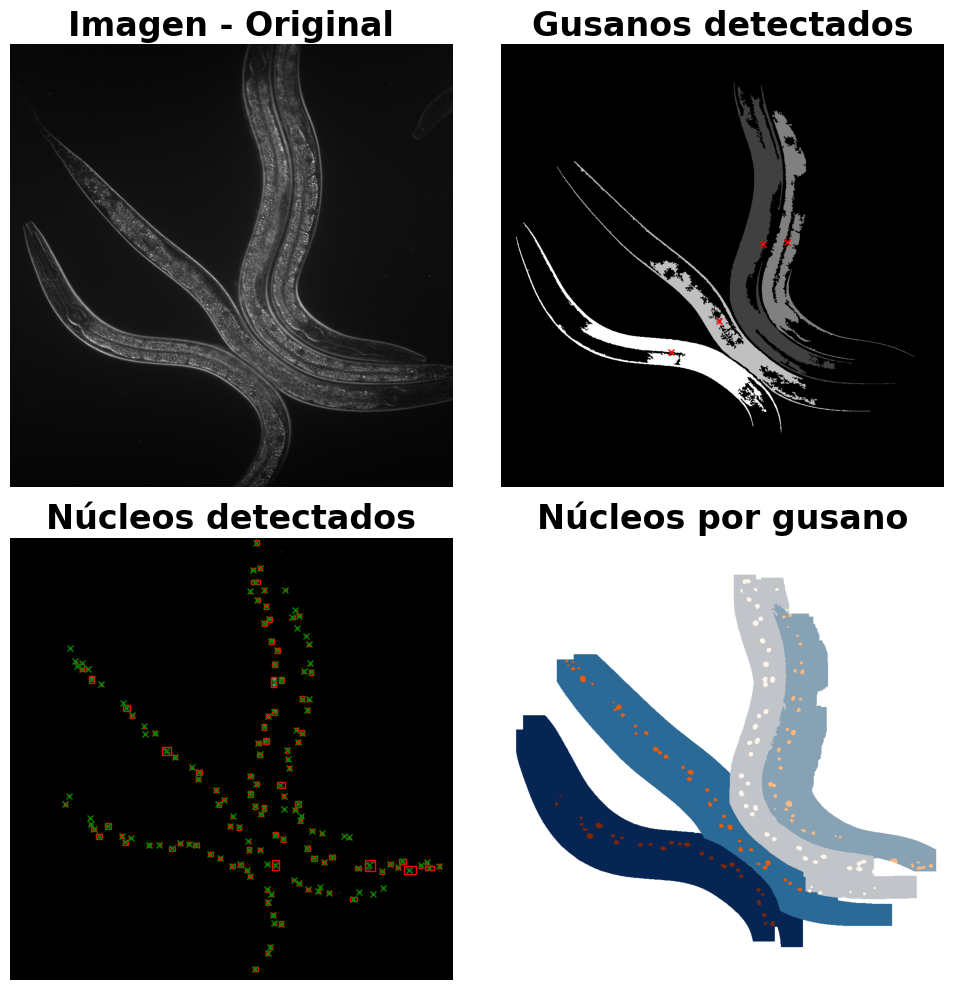

In [162]:
nuevoRastreador = WormTracker(ruta_prueba_1)
nuevoRastreador.procesarImagen(thresholdCampoClaro=0.275, thresholdFluo=0.05)
nuevoRastreador.buscarNucleos(tol_cerrada = 5, tol_abierta = 5)
nuevoRastreador.coordenadasDeNucleos()
nuevoRastreador.centroidesDeNucleos()
nuevoRastreador.buscarGusanos(tol_cerrada=1, iteraciones=8, con_rellenado_inundacion=True,
                             min_area=3500, tol_rellenado=2, max_iteracion=25)
nuevoRastreador.coordenadasDeGusanos()
nuevoRastreador.interseccionGusanoNucleos()
nuevoRastreador.graficarProcesamiento(modos=[0, 1, 3, 4])